In [272]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression
import statistics
from datetime import datetime
import functools
import matplotlib.pyplot as plt

In [273]:
food_pricing_path = r"Data/Pricing/RPI"
fert_pricing_path = r"Data/Pricing"

cereals_pricing = pd.read_csv(
    f'{food_pricing_path}/RPI_cereals.csv',
    header=8,
    usecols = ['Date', 'Cereals'],
    names=['Date', 'Cereals']
    )

eggs_pricing = pd.read_csv(
    f'{food_pricing_path}/RPI_eggs.csv',
    header=8,
    usecols = ['Date', 'Eggs'],
    names=['Date', 'Eggs']
    )

fruit_pricing = pd.read_csv(
    f'{food_pricing_path}/RPI_fruit.csv',
    header=8,
    usecols = ['Date', 'Fruit'],
    names=['Date', 'Fruit']
    )

poultry_pricing = pd.read_csv(
    f'{food_pricing_path}/RPI_poultry.csv',
    header=8,
    usecols = ['Date', 'Poultry'],
    names=['Date', 'Poultry']
    )

sugar_pricing = pd.read_csv(
    f'{food_pricing_path}/RPI_sugarandpreserves.csv',
    header=8,
    usecols = ['Date', 'Sugar'],
    names=['Date', 'Sugar']
    )

veg_pricing = pd.read_csv(
    f'{food_pricing_path}/RPI_vegetables.csv',
    header=8,
    usecols = ['Date', 'Vegetables'],
    names=['Date', 'Vegetables']
    )

to_b_merged = [veg_pricing, sugar_pricing, poultry_pricing, fruit_pricing, eggs_pricing, cereals_pricing]
food_merged = functools.reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='outer'), to_b_merged)

fert_pricing = pd.read_excel(
    f'{fert_pricing_path}/FertPrices.xlsx'
    )

Made changes to pricing similar to fertiliser pricing: converting all veg prices to a min max scaled average to get a general picture if food pricing went up

In [276]:
def food_pricing(df):
    # Sort the DataFrame by Date
    df.sort_values(by='Date', inplace=True)
    minmax_array = pd.DataFrame({'Date':df['Date']})
    
    for column in df.columns[1:]:
        max = df[column].max()
        min = df[column].min()
        minmax = (df[column] - min) / (max - min)
        minmax_array[column] = minmax

    minmax_array['Scaled Average'] = minmax_array.mean(axis=1, numeric_only=True)
    
    
    return minmax_array[['Date', 'Scaled Average']]
        
        
food_pricing_sa = food_pricing(food_merged)

In [277]:
def stdz_pricing(data):
    data_no_date = data.drop(columns=['Month'])
    min_values = data_no_date.min(axis=0)
    max_values = data_no_date.max(axis=0)
    
    scaled_df = (data_no_date - min_values) / (max_values - min_values)
    data['Scaled Average'] = scaled_df.mean(axis=1)
    data.rename(columns = {"Month":'Date'}, inplace = True)
    
    return data

fert_pricing = stdz_pricing(fert_pricing)
fert_sa = fert_pricing[['Date', 'Scaled Average']]

In [301]:
def outlier_id(df):
    # Convert date column to datetime type
    def convert_to_yyyymmdd(date_string):
        datetime_obj = datetime.strptime(date_string, '%d/%m/%Y')
        return datetime_obj.strftime('%Y%m%d')

    # Apply the custom function to each element in the 'date' column
    if type(df['Date'][1]) == str:
        df['Date'] = df['Date'].apply(convert_to_yyyymmdd)
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    
    std = df['Scaled Average'].std()
    
    # Fit linear regression
    X = np.arange(len(df)).reshape(-1, 1) # Using row numbers as index for linear regression
    y = df['Scaled Average'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    
    # Predict values
    predicted_values = reg.predict(X)
    residuals = y - predicted_values
    
    df.loc[:,'Predicted Value'] = predicted_values
    result = pd.DataFrame(columns=['Outlier'])
    n_results = 20
    
    for n in reversed(range(0,200,5)): # range() cant deal with float -> (0,200,5) == (0,2,0.05)
        result = np.where(abs(residuals) >= (n/100)* std, 1, 0) # counts down the std threshold

        if len(result[result == 1]) >= n_results:
            break
        
    df.loc[:,'Outlier'] = result
    
    return df
    
x = outlier_id(fert_sa)
y = outlier_id(food_pricing_sa)

Noticed that the reversed range will pick out the 

In [302]:
print(f'{x}\n {y}')

         Date  Scaled Average  Predicted Value  Outlier
0  2017-01-01        0.052879        -0.053265        0
1  2017-02-01        0.062073        -0.046197        0
2  2017-03-01        0.061176        -0.039129        0
3  2017-04-01        0.057294        -0.032061        0
4  2017-05-01        0.044631        -0.024993        0
..        ...             ...              ...      ...
82 2023-11-01        0.292089         0.526313        1
83 2023-12-01        0.277249         0.533381        1
84 2024-01-01        0.266214         0.540449        1
85 2024-02-01        0.259490         0.547517        1
86 2024-03-01        0.253267         0.554585        1

[87 rows x 4 columns]
           Date  Scaled Average  Predicted Value  Outlier
0   1987-01-01        0.006626         0.358507        0
1   1988-01-01        0.039448         0.358664        0
2   1989-01-01        0.059871         0.358820        0
3   1990-01-01        0.136526         0.358977        0
4   1991-01-01     

<Axes: xlabel='Date', ylabel='Scaled Average'>

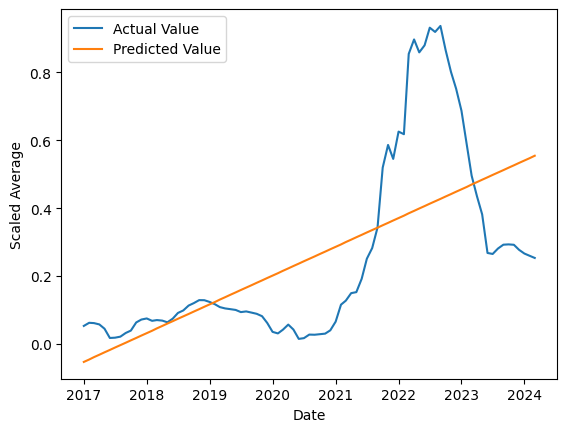

In [298]:
sns.lineplot(x='Date', y='Scaled Average', data=x, label='Actual Value')
sns.lineplot(x='Date', y='Predicted Value', data=x, label='Predicted Value')

Cant have negative values in the prediction so will have to change the predicition strategy

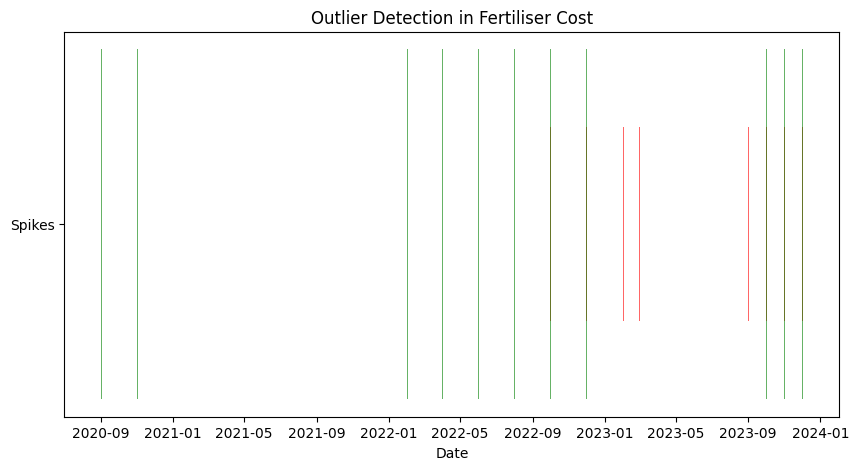

In [300]:
# Define duration (1 day in this case)
duration = pd.Timedelta(days=1)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

l_cutoff = '2017-01-01'
u_cutoff = '2024-01-01'
food_cost = food_pricing_sa[(food_pricing_sa['Date'] > l_cutoff) & (food_pricing_sa['Date'] < u_cutoff)]
 
# Plot the food pricing data  
x = 'Spikes'
    
for i, row in food_cost.iterrows():
    if row['Outlier'] == 1:
            color = 'red'  # Green for True, Red for False
            ax.barh(x,duration, left = row['Date'] , color=color, alpha=0.6, height = 0.5 )

# Plot the fertiliser cost spikes
fert_cost = fert_sa[(fert_sa['Date'] > l_cutoff) & (fert_sa['Date'] < u_cutoff)]

for i, row in fert_cost.iterrows():
    if row['Outlier'] == 1:
        color = 'green'  # Green for True, Red for False
        ax.barh(x,duration, left = row['Date'] , color = color, alpha=0.6, height=0.9)


# Set labels and title
ax.set_xlabel('Date')
ax.set_title('Outlier Detection in Fertiliser Cost')

# Set x-axis date format
ax.xaxis_date()

# Show plot
plt.show()